In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from glob import *
import cv2
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [2]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 500 # number of epochs to train the SRCNN model for
lr = 0.0001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# input image dimensions
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [4]:
file = h5py.File('input/train_mscale.h5')
# `in_train` has shape (21884, 33, 33, 1) which corresponds to
# 21884 image patches of 33 pixels height & width and 1 color channel
in_train = file['data'][:] # the training data
out_train = file['label'][:] # the training labels
file.close()
# change the values to float32
in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [5]:
len(in_train)

21824

In [6]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Training samples:  16368
Validation samples:  5456


In [7]:
class SRCNNDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [8]:
# train and validation data
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [9]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2, padding_mode='replicate')
        self.conv3=nn.Conv2d(64, 128, kernel_size=7, padding=3, padding_mode='replicate')
        self.conv4=nn.Conv2d(128, 64, kernel_size=7, padding=3, padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, 32, kernel_size=5, padding=2, padding_mode='replicate')
        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, padding=1, padding_mode='replicate')
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
#         print(x1.size())
        x2 = F.relu(self.conv2(x1))
#         print(x2.size())
        x3= F.relu(self.conv3(x2))
#         print(x3.size())
        x4= F.relu(self.conv4(x3))
#         print(x4.size())
        x5= F.relu(self.conv5(x4+x2))
#         print(x5.size())
        x6=self.conv6(x5+x1)
        return x6

In [10]:
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
  (conv4): Conv2d(128, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
)


In [11]:
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [12]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [13]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()

        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [14]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"val_outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [15]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")
torch.save(model,'S6model/DIPmode____.pt')
# torch.Size([64, 64, 29, 29])

Epoch 1 of 500


256it [00:18, 13.85it/s]                                                                                               
86it [00:01, 45.78it/s]                                                                                                


Train PSNR: 24.499
Val PSNR: 27.544
Epoch 2 of 500


256it [00:13, 19.25it/s]                                                                                               
86it [00:01, 45.71it/s]                                                                                                


Train PSNR: 27.783
Val PSNR: 28.088
Epoch 3 of 500


256it [00:13, 19.22it/s]                                                                                               
86it [00:01, 45.69it/s]                                                                                                


Train PSNR: 28.071
Val PSNR: 28.306
Epoch 4 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.57it/s]                                                                                                


Train PSNR: 28.192
Val PSNR: 28.405
Epoch 5 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.41it/s]                                                                                                


Train PSNR: 28.270
Val PSNR: 28.469
Epoch 6 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.49it/s]                                                                                                


Train PSNR: 28.315
Val PSNR: 28.512
Epoch 7 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.43it/s]                                                                                                


Train PSNR: 28.350
Val PSNR: 28.502
Epoch 8 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.49it/s]                                                                                                


Train PSNR: 28.378
Val PSNR: 28.538
Epoch 9 of 500


256it [00:13, 19.17it/s]                                                                                               
86it [00:01, 45.38it/s]                                                                                                


Train PSNR: 28.264
Val PSNR: 28.593
Epoch 10 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.36it/s]                                                                                                


Train PSNR: 28.460
Val PSNR: 28.629
Epoch 11 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.59it/s]                                                                                                


Train PSNR: 28.486
Val PSNR: 28.654
Epoch 12 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.50it/s]                                                                                                


Train PSNR: 28.487
Val PSNR: 28.649
Epoch 13 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.31it/s]                                                                                                


Train PSNR: 28.498
Val PSNR: 28.695
Epoch 14 of 500


256it [00:13, 19.11it/s]                                                                                               
86it [00:01, 44.98it/s]                                                                                                


Train PSNR: 28.522
Val PSNR: 28.656
Epoch 15 of 500


256it [00:13, 18.98it/s]                                                                                               
86it [00:01, 45.45it/s]                                                                                                


Train PSNR: 28.539
Val PSNR: 28.741
Epoch 16 of 500


256it [00:13, 19.06it/s]                                                                                               
86it [00:01, 45.09it/s]                                                                                                


Train PSNR: 28.564
Val PSNR: 28.721
Epoch 17 of 500


256it [00:13, 19.06it/s]                                                                                               
86it [00:01, 45.13it/s]                                                                                                


Train PSNR: 28.586
Val PSNR: 28.768
Epoch 18 of 500


256it [00:13, 19.07it/s]                                                                                               
86it [00:01, 44.97it/s]                                                                                                


Train PSNR: 28.610
Val PSNR: 28.804
Epoch 19 of 500


256it [00:13, 19.03it/s]                                                                                               
86it [00:01, 44.39it/s]                                                                                                


Train PSNR: 28.645
Val PSNR: 28.810
Epoch 20 of 500


256it [00:13, 19.03it/s]                                                                                               
86it [00:01, 45.19it/s]                                                                                                


Train PSNR: 28.673
Val PSNR: 28.869
Epoch 21 of 500


256it [00:13, 19.06it/s]                                                                                               
86it [00:01, 45.02it/s]                                                                                                


Train PSNR: 28.698
Val PSNR: 28.887
Epoch 22 of 500


256it [00:13, 19.07it/s]                                                                                               
86it [00:01, 44.91it/s]                                                                                                


Train PSNR: 28.734
Val PSNR: 28.932
Epoch 23 of 500


256it [00:13, 19.05it/s]                                                                                               
86it [00:01, 45.04it/s]                                                                                                


Train PSNR: 28.759
Val PSNR: 28.959
Epoch 24 of 500


256it [00:13, 19.05it/s]                                                                                               
86it [00:01, 45.01it/s]                                                                                                


Train PSNR: 28.788
Val PSNR: 28.987
Epoch 25 of 500


256it [00:13, 19.04it/s]                                                                                               
86it [00:01, 45.04it/s]                                                                                                


Train PSNR: 28.816
Val PSNR: 29.020
Epoch 26 of 500


256it [00:13, 18.89it/s]                                                                                               
86it [00:01, 44.44it/s]                                                                                                


Train PSNR: 28.848
Val PSNR: 29.039
Epoch 27 of 500


256it [00:13, 18.72it/s]                                                                                               
86it [00:01, 44.14it/s]                                                                                                


Train PSNR: 28.867
Val PSNR: 29.075
Epoch 28 of 500


256it [00:13, 18.84it/s]                                                                                               
86it [00:01, 43.78it/s]                                                                                                


Train PSNR: 28.896
Val PSNR: 29.096
Epoch 29 of 500


256it [00:13, 18.71it/s]                                                                                               
86it [00:01, 43.65it/s]                                                                                                


Train PSNR: 28.918
Val PSNR: 29.116
Epoch 30 of 500


256it [00:13, 18.71it/s]                                                                                               
86it [00:01, 43.66it/s]                                                                                                


Train PSNR: 28.929
Val PSNR: 29.138
Epoch 31 of 500


256it [00:13, 18.70it/s]                                                                                               
86it [00:01, 43.65it/s]                                                                                                


Train PSNR: 28.969
Val PSNR: 29.161
Epoch 32 of 500


256it [00:13, 18.71it/s]                                                                                               
86it [00:01, 43.67it/s]                                                                                                


Train PSNR: 28.979
Val PSNR: 29.171
Epoch 33 of 500


256it [00:13, 18.70it/s]                                                                                               
86it [00:01, 43.70it/s]                                                                                                


Train PSNR: 29.000
Val PSNR: 29.193
Epoch 34 of 500


256it [00:13, 18.72it/s]                                                                                               
86it [00:01, 43.66it/s]                                                                                                


Train PSNR: 29.015
Val PSNR: 29.203
Epoch 35 of 500


256it [00:13, 18.72it/s]                                                                                               
86it [00:01, 43.59it/s]                                                                                                


Train PSNR: 29.040
Val PSNR: 29.174
Epoch 36 of 500


256it [00:13, 18.71it/s]                                                                                               
86it [00:01, 43.66it/s]                                                                                                


Train PSNR: 29.047
Val PSNR: 29.229
Epoch 37 of 500


256it [00:13, 18.72it/s]                                                                                               
86it [00:01, 43.69it/s]                                                                                                


Train PSNR: 29.062
Val PSNR: 29.229
Epoch 38 of 500


256it [00:13, 18.68it/s]                                                                                               
86it [00:02, 42.73it/s]                                                                                                


Train PSNR: 29.080
Val PSNR: 29.213
Epoch 39 of 500


256it [00:16, 15.78it/s]                                                                                               
86it [00:03, 25.15it/s]                                                                                                


Train PSNR: 29.092
Val PSNR: 29.214
Epoch 40 of 500


256it [00:26,  9.72it/s]                                                                                               
86it [00:03, 25.26it/s]                                                                                                


Train PSNR: 29.109
Val PSNR: 29.275
Epoch 41 of 500


256it [00:25, 10.06it/s]                                                                                               
86it [00:03, 25.48it/s]                                                                                                


Train PSNR: 29.121
Val PSNR: 29.299
Epoch 42 of 500


256it [00:25, 10.12it/s]                                                                                               
86it [00:03, 25.63it/s]                                                                                                


Train PSNR: 29.132
Val PSNR: 29.273
Epoch 43 of 500


256it [00:24, 10.36it/s]                                                                                               
86it [00:03, 25.58it/s]                                                                                                


Train PSNR: 29.151
Val PSNR: 29.318
Epoch 44 of 500


256it [00:24, 10.42it/s]                                                                                               
86it [00:03, 26.02it/s]                                                                                                


Train PSNR: 29.159
Val PSNR: 29.334
Epoch 45 of 500


256it [00:24, 10.53it/s]                                                                                               
86it [00:03, 26.38it/s]                                                                                                


Train PSNR: 29.172
Val PSNR: 29.346
Epoch 46 of 500


256it [00:24, 10.45it/s]                                                                                               
86it [00:03, 26.30it/s]                                                                                                


Train PSNR: 29.182
Val PSNR: 29.350
Epoch 47 of 500


256it [00:24, 10.50it/s]                                                                                               
86it [00:03, 26.77it/s]                                                                                                


Train PSNR: 29.195
Val PSNR: 29.362
Epoch 48 of 500


256it [00:24, 10.48it/s]                                                                                               
86it [00:03, 26.95it/s]                                                                                                


Train PSNR: 29.205
Val PSNR: 29.375
Epoch 49 of 500


256it [00:24, 10.54it/s]                                                                                               
86it [00:03, 26.99it/s]                                                                                                


Train PSNR: 29.216
Val PSNR: 29.384
Epoch 50 of 500


256it [00:24, 10.61it/s]                                                                                               
86it [00:03, 27.63it/s]                                                                                                


Train PSNR: 29.228
Val PSNR: 29.394
Epoch 51 of 500


256it [00:24, 10.62it/s]                                                                                               
86it [00:03, 27.05it/s]                                                                                                


Train PSNR: 29.238
Val PSNR: 29.396
Epoch 52 of 500


256it [00:23, 10.68it/s]                                                                                               
86it [00:03, 27.43it/s]                                                                                                


Train PSNR: 29.250
Val PSNR: 29.402
Epoch 53 of 500


256it [00:23, 10.68it/s]                                                                                               
86it [00:03, 27.61it/s]                                                                                                


Train PSNR: 29.259
Val PSNR: 29.409
Epoch 54 of 500


256it [00:23, 10.71it/s]                                                                                               
86it [00:03, 27.16it/s]                                                                                                


Train PSNR: 29.271
Val PSNR: 29.416
Epoch 55 of 500


256it [00:23, 10.71it/s]                                                                                               
86it [00:03, 27.56it/s]                                                                                                


Train PSNR: 29.280
Val PSNR: 29.426
Epoch 56 of 500


256it [00:23, 10.68it/s]                                                                                               
86it [00:03, 27.49it/s]                                                                                                


Train PSNR: 29.289
Val PSNR: 29.358
Epoch 57 of 500


256it [00:23, 10.71it/s]                                                                                               
86it [00:03, 27.36it/s]                                                                                                


Train PSNR: 29.297
Val PSNR: 29.439
Epoch 58 of 500


256it [00:23, 10.67it/s]                                                                                               
86it [00:03, 27.37it/s]                                                                                                


Train PSNR: 29.311
Val PSNR: 29.429
Epoch 59 of 500


256it [00:23, 10.72it/s]                                                                                               
86it [00:03, 27.43it/s]                                                                                                


Train PSNR: 29.317
Val PSNR: 29.449
Epoch 60 of 500


256it [00:23, 10.77it/s]                                                                                               
86it [00:03, 27.63it/s]                                                                                                


Train PSNR: 29.326
Val PSNR: 29.454
Epoch 61 of 500


256it [00:23, 10.77it/s]                                                                                               
86it [00:03, 27.81it/s]                                                                                                


Train PSNR: 29.335
Val PSNR: 29.462
Epoch 62 of 500


256it [00:23, 10.77it/s]                                                                                               
86it [00:03, 27.78it/s]                                                                                                


Train PSNR: 29.342
Val PSNR: 29.465
Epoch 63 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.60it/s]                                                                                                


Train PSNR: 29.347
Val PSNR: 29.459
Epoch 64 of 500


256it [00:23, 10.76it/s]                                                                                               
86it [00:03, 27.70it/s]                                                                                                


Train PSNR: 29.361
Val PSNR: 29.461
Epoch 65 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.66it/s]                                                                                                


Train PSNR: 29.369
Val PSNR: 29.467
Epoch 66 of 500


256it [00:23, 10.79it/s]                                                                                               
86it [00:03, 27.58it/s]                                                                                                


Train PSNR: 29.377
Val PSNR: 29.475
Epoch 67 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.68it/s]                                                                                                


Train PSNR: 29.385
Val PSNR: 29.484
Epoch 68 of 500


256it [00:23, 10.75it/s]                                                                                               
86it [00:03, 27.37it/s]                                                                                                


Train PSNR: 29.393
Val PSNR: 29.485
Epoch 69 of 500


256it [00:23, 10.79it/s]                                                                                               
86it [00:03, 27.85it/s]                                                                                                


Train PSNR: 29.401
Val PSNR: 29.483
Epoch 70 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.77it/s]                                                                                                


Train PSNR: 29.408
Val PSNR: 29.484
Epoch 71 of 500


256it [00:23, 10.80it/s]                                                                                               
86it [00:03, 27.72it/s]                                                                                                


Train PSNR: 29.416
Val PSNR: 29.498
Epoch 72 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.95it/s]                                                                                                


Train PSNR: 29.424
Val PSNR: 29.500
Epoch 73 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.92it/s]                                                                                                


Train PSNR: 29.432
Val PSNR: 29.504
Epoch 74 of 500


256it [00:23, 10.82it/s]                                                                                               
86it [00:03, 27.70it/s]                                                                                                


Train PSNR: 29.439
Val PSNR: 29.511
Epoch 75 of 500


256it [00:23, 10.82it/s]                                                                                               
86it [00:03, 27.85it/s]                                                                                                


Train PSNR: 29.446
Val PSNR: 29.513
Epoch 76 of 500


256it [00:23, 10.87it/s]                                                                                               
86it [00:03, 28.05it/s]                                                                                                


Train PSNR: 29.454
Val PSNR: 29.528
Epoch 77 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.89it/s]                                                                                                


Train PSNR: 29.461
Val PSNR: 29.524
Epoch 78 of 500


256it [00:23, 10.85it/s]                                                                                               
86it [00:03, 27.87it/s]                                                                                                


Train PSNR: 29.468
Val PSNR: 29.528
Epoch 79 of 500


256it [00:23, 10.86it/s]                                                                                               
86it [00:03, 27.87it/s]                                                                                                


Train PSNR: 29.474
Val PSNR: 29.535
Epoch 80 of 500


256it [00:23, 10.75it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.481
Val PSNR: 29.544
Epoch 81 of 500


256it [00:23, 10.80it/s]                                                                                               
86it [00:03, 27.95it/s]                                                                                                


Train PSNR: 29.488
Val PSNR: 29.549
Epoch 82 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 28.04it/s]                                                                                                


Train PSNR: 29.495
Val PSNR: 29.553
Epoch 83 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.95it/s]                                                                                                


Train PSNR: 29.501
Val PSNR: 29.564
Epoch 84 of 500


256it [00:23, 10.83it/s]                                                                                               
86it [00:03, 27.69it/s]                                                                                                


Train PSNR: 29.509
Val PSNR: 29.562
Epoch 85 of 500


256it [00:23, 10.80it/s]                                                                                               
86it [00:03, 27.94it/s]                                                                                                


Train PSNR: 29.514
Val PSNR: 29.574
Epoch 86 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.76it/s]                                                                                                


Train PSNR: 29.521
Val PSNR: 29.571
Epoch 87 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 28.18it/s]                                                                                                


Train PSNR: 29.528
Val PSNR: 29.580
Epoch 88 of 500


256it [00:23, 10.85it/s]                                                                                               
86it [00:03, 28.00it/s]                                                                                                


Train PSNR: 29.535
Val PSNR: 29.587
Epoch 89 of 500


256it [00:23, 10.82it/s]                                                                                               
86it [00:03, 27.86it/s]                                                                                                


Train PSNR: 29.541
Val PSNR: 29.591
Epoch 90 of 500


256it [00:23, 10.83it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.547
Val PSNR: 29.596
Epoch 91 of 500


256it [00:23, 10.85it/s]                                                                                               
86it [00:03, 27.71it/s]                                                                                                


Train PSNR: 29.554
Val PSNR: 29.600
Epoch 92 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.561
Val PSNR: 29.600
Epoch 93 of 500


256it [00:23, 10.87it/s]                                                                                               
86it [00:03, 28.02it/s]                                                                                                


Train PSNR: 29.566
Val PSNR: 29.603
Epoch 94 of 500


256it [00:23, 10.87it/s]                                                                                               
86it [00:03, 28.22it/s]                                                                                                


Train PSNR: 29.573
Val PSNR: 29.606
Epoch 95 of 500


256it [00:23, 10.86it/s]                                                                                               
86it [00:03, 28.19it/s]                                                                                                


Train PSNR: 29.577
Val PSNR: 29.613
Epoch 96 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.95it/s]                                                                                                


Train PSNR: 29.583
Val PSNR: 29.620
Epoch 97 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.98it/s]                                                                                                


Train PSNR: 29.589
Val PSNR: 29.624
Epoch 98 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.87it/s]                                                                                                


Train PSNR: 29.593
Val PSNR: 29.630
Epoch 99 of 500


256it [00:23, 10.86it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.599
Val PSNR: 29.632
Epoch 100 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.88it/s]                                                                                                


Train PSNR: 29.605
Val PSNR: 29.636
Epoch 101 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.77it/s]                                                                                                


Train PSNR: 29.611
Val PSNR: 29.639
Epoch 102 of 500


256it [00:23, 10.76it/s]                                                                                               
86it [00:03, 27.69it/s]                                                                                                


Train PSNR: 29.616
Val PSNR: 29.648
Epoch 103 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.89it/s]                                                                                                


Train PSNR: 29.621
Val PSNR: 29.650
Epoch 104 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.72it/s]                                                                                                


Train PSNR: 29.627
Val PSNR: 29.658
Epoch 105 of 500


256it [00:23, 10.78it/s]                                                                                               
86it [00:03, 27.55it/s]                                                                                                


Train PSNR: 29.632
Val PSNR: 29.661
Epoch 106 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.92it/s]                                                                                                


Train PSNR: 29.637
Val PSNR: 29.660
Epoch 107 of 500


256it [00:23, 10.82it/s]                                                                                               
86it [00:03, 28.01it/s]                                                                                                


Train PSNR: 29.641
Val PSNR: 29.669
Epoch 108 of 500


256it [00:23, 10.83it/s]                                                                                               
86it [00:03, 27.85it/s]                                                                                                


Train PSNR: 29.647
Val PSNR: 29.670
Epoch 109 of 500


256it [00:23, 10.89it/s]                                                                                               
86it [00:03, 28.13it/s]                                                                                                


Train PSNR: 29.651
Val PSNR: 29.677
Epoch 110 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.88it/s]                                                                                                


Train PSNR: 29.656
Val PSNR: 29.680
Epoch 111 of 500


256it [00:23, 10.79it/s]                                                                                               
86it [00:03, 27.96it/s]                                                                                                


Train PSNR: 29.660
Val PSNR: 29.681
Epoch 112 of 500


256it [00:23, 10.88it/s]                                                                                               
86it [00:03, 27.83it/s]                                                                                                


Train PSNR: 29.664
Val PSNR: 29.676
Epoch 113 of 500


256it [00:23, 10.88it/s]                                                                                               
86it [00:03, 28.09it/s]                                                                                                


Train PSNR: 29.670
Val PSNR: 29.672
Epoch 114 of 500


256it [00:13, 18.87it/s]                                                                                               
86it [00:01, 45.49it/s]                                                                                                


Train PSNR: 29.676
Val PSNR: 29.693
Epoch 115 of 500


256it [00:13, 19.23it/s]                                                                                               
86it [00:01, 45.79it/s]                                                                                                


Train PSNR: 29.681
Val PSNR: 29.697
Epoch 116 of 500


256it [00:13, 19.25it/s]                                                                                               
86it [00:01, 45.56it/s]                                                                                                


Train PSNR: 29.687
Val PSNR: 29.699
Epoch 117 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.52it/s]                                                                                                


Train PSNR: 29.691
Val PSNR: 29.706
Epoch 118 of 500


256it [00:13, 19.23it/s]                                                                                               
86it [00:01, 45.49it/s]                                                                                                


Train PSNR: 29.697
Val PSNR: 29.705
Epoch 119 of 500


256it [00:13, 19.17it/s]                                                                                               
86it [00:01, 45.42it/s]                                                                                                


Train PSNR: 29.703
Val PSNR: 29.709
Epoch 120 of 500


256it [00:13, 19.22it/s]                                                                                               
86it [00:01, 45.63it/s]                                                                                                


Train PSNR: 29.707
Val PSNR: 29.716
Epoch 121 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.51it/s]                                                                                                


Train PSNR: 29.713
Val PSNR: 29.720
Epoch 122 of 500


256it [00:13, 19.18it/s]                                                                                               
86it [00:01, 45.47it/s]                                                                                                


Train PSNR: 29.718
Val PSNR: 29.726
Epoch 123 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 29.723
Val PSNR: 29.724
Epoch 124 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.25it/s]                                                                                                


Train PSNR: 29.728
Val PSNR: 29.732
Epoch 125 of 500


256it [00:13, 19.11it/s]                                                                                               
86it [00:01, 45.32it/s]                                                                                                


Train PSNR: 29.732
Val PSNR: 29.737
Epoch 126 of 500


256it [00:13, 19.10it/s]                                                                                               
86it [00:01, 45.11it/s]                                                                                                


Train PSNR: 29.738
Val PSNR: 29.744
Epoch 127 of 500


256it [00:13, 19.08it/s]                                                                                               
86it [00:01, 45.15it/s]                                                                                                


Train PSNR: 29.743
Val PSNR: 29.744
Epoch 128 of 500


256it [00:13, 18.94it/s]                                                                                               
86it [00:01, 44.04it/s]                                                                                                


Train PSNR: 29.748
Val PSNR: 29.747
Epoch 129 of 500


256it [00:13, 18.89it/s]                                                                                               
86it [00:01, 44.27it/s]                                                                                                


Train PSNR: 29.752
Val PSNR: 29.754
Epoch 130 of 500


256it [00:13, 18.91it/s]                                                                                               
86it [00:01, 43.93it/s]                                                                                                


Train PSNR: 29.757
Val PSNR: 29.758
Epoch 131 of 500


256it [00:13, 18.70it/s]                                                                                               
86it [00:01, 43.94it/s]                                                                                                


Train PSNR: 29.761
Val PSNR: 29.762
Epoch 132 of 500


256it [00:13, 18.81it/s]                                                                                               
86it [00:01, 43.86it/s]                                                                                                


Train PSNR: 29.766
Val PSNR: 29.765
Epoch 133 of 500


256it [00:13, 18.57it/s]                                                                                               
86it [00:01, 43.37it/s]                                                                                                


Train PSNR: 29.771
Val PSNR: 29.768
Epoch 134 of 500


256it [00:13, 18.58it/s]                                                                                               
86it [00:01, 43.31it/s]                                                                                                


Train PSNR: 29.776
Val PSNR: 29.772
Epoch 135 of 500


256it [00:13, 18.58it/s]                                                                                               
86it [00:01, 43.01it/s]                                                                                                


Train PSNR: 29.780
Val PSNR: 29.775
Epoch 136 of 500


256it [00:13, 18.56it/s]                                                                                               
86it [00:01, 43.32it/s]                                                                                                


Train PSNR: 29.785
Val PSNR: 29.780
Epoch 137 of 500


256it [00:13, 18.56it/s]                                                                                               
86it [00:01, 43.37it/s]                                                                                                


Train PSNR: 29.790
Val PSNR: 29.782
Epoch 138 of 500


256it [00:13, 18.57it/s]                                                                                               
86it [00:01, 43.06it/s]                                                                                                


Train PSNR: 29.794
Val PSNR: 29.784
Epoch 139 of 500


256it [00:13, 18.55it/s]                                                                                               
86it [00:01, 43.29it/s]                                                                                                


Train PSNR: 29.799
Val PSNR: 29.787
Epoch 140 of 500


256it [00:13, 18.58it/s]                                                                                               
86it [00:02, 42.45it/s]                                                                                                


Train PSNR: 29.804
Val PSNR: 29.789
Epoch 141 of 500


256it [00:13, 18.48it/s]                                                                                               
86it [00:01, 43.01it/s]                                                                                                


Train PSNR: 29.809
Val PSNR: 29.791
Epoch 142 of 500


256it [00:13, 18.48it/s]                                                                                               
86it [00:01, 43.09it/s]                                                                                                


Train PSNR: 29.812
Val PSNR: 29.794
Epoch 143 of 500


256it [00:13, 18.47it/s]                                                                                               
86it [00:01, 43.01it/s]                                                                                                


Train PSNR: 29.817
Val PSNR: 29.796
Epoch 144 of 500


256it [00:13, 18.42it/s]                                                                                               
86it [00:02, 42.92it/s]                                                                                                


Train PSNR: 29.821
Val PSNR: 29.797
Epoch 145 of 500


256it [00:13, 18.41it/s]                                                                                               
86it [00:02, 42.88it/s]                                                                                                


Train PSNR: 29.825
Val PSNR: 29.800
Epoch 146 of 500


256it [00:13, 18.37it/s]                                                                                               
86it [00:02, 42.84it/s]                                                                                                


Train PSNR: 29.828
Val PSNR: 29.804
Epoch 147 of 500


256it [00:13, 18.37it/s]                                                                                               
86it [00:02, 42.90it/s]                                                                                                


Train PSNR: 29.832
Val PSNR: 29.807
Epoch 148 of 500


256it [00:13, 18.39it/s]                                                                                               
86it [00:02, 42.73it/s]                                                                                                


Train PSNR: 29.835
Val PSNR: 29.807
Epoch 149 of 500


256it [00:13, 18.37it/s]                                                                                               
86it [00:02, 42.79it/s]                                                                                                


Train PSNR: 29.839
Val PSNR: 29.808
Epoch 150 of 500


256it [00:13, 18.36it/s]                                                                                               
86it [00:02, 42.89it/s]                                                                                                


Train PSNR: 29.843
Val PSNR: 29.807
Epoch 151 of 500


256it [00:13, 18.38it/s]                                                                                               
86it [00:02, 42.86it/s]                                                                                                


Train PSNR: 29.846
Val PSNR: 29.809
Epoch 152 of 500


256it [00:13, 18.39it/s]                                                                                               
86it [00:02, 42.84it/s]                                                                                                


Train PSNR: 29.850
Val PSNR: 29.811
Epoch 153 of 500


256it [00:17, 14.35it/s]                                                                                               
86it [00:03, 25.24it/s]                                                                                                


Train PSNR: 29.854
Val PSNR: 29.812
Epoch 154 of 500


256it [00:26,  9.78it/s]                                                                                               
86it [00:03, 25.13it/s]                                                                                                


Train PSNR: 29.858
Val PSNR: 29.815
Epoch 155 of 500


256it [00:25, 10.06it/s]                                                                                               
86it [00:03, 25.28it/s]                                                                                                


Train PSNR: 29.862
Val PSNR: 29.820
Epoch 156 of 500


256it [00:25, 10.21it/s]                                                                                               
86it [00:03, 25.73it/s]                                                                                                


Train PSNR: 29.867
Val PSNR: 29.822
Epoch 157 of 500


256it [00:24, 10.28it/s]                                                                                               
86it [00:03, 25.70it/s]                                                                                                


Train PSNR: 29.870
Val PSNR: 29.824
Epoch 158 of 500


256it [00:24, 10.48it/s]                                                                                               
86it [00:03, 25.98it/s]                                                                                                


Train PSNR: 29.874
Val PSNR: 29.827
Epoch 159 of 500


256it [00:24, 10.55it/s]                                                                                               
86it [00:03, 25.78it/s]                                                                                                


Train PSNR: 29.879
Val PSNR: 29.830
Epoch 160 of 500


256it [00:24, 10.55it/s]                                                                                               
86it [00:03, 26.33it/s]                                                                                                


Train PSNR: 29.883
Val PSNR: 29.832
Epoch 161 of 500


256it [00:24, 10.66it/s]                                                                                               
86it [00:03, 27.02it/s]                                                                                                


Train PSNR: 29.887
Val PSNR: 29.834
Epoch 162 of 500


256it [00:24, 10.65it/s]                                                                                               
86it [00:03, 26.89it/s]                                                                                                


Train PSNR: 29.891
Val PSNR: 29.836
Epoch 163 of 500


256it [00:24, 10.66it/s]                                                                                               
86it [00:03, 26.87it/s]                                                                                                


Train PSNR: 29.895
Val PSNR: 29.835
Epoch 164 of 500


256it [00:23, 10.72it/s]                                                                                               
86it [00:03, 27.25it/s]                                                                                                


Train PSNR: 29.899
Val PSNR: 29.838
Epoch 165 of 500


256it [00:23, 10.73it/s]                                                                                               
86it [00:03, 27.24it/s]                                                                                                


Train PSNR: 29.903
Val PSNR: 29.840
Epoch 166 of 500


256it [00:23, 10.72it/s]                                                                                               
86it [00:03, 27.74it/s]                                                                                                


Train PSNR: 29.907
Val PSNR: 29.842
Epoch 167 of 500


256it [00:23, 10.72it/s]                                                                                               
86it [00:03, 27.34it/s]                                                                                                


Train PSNR: 29.911
Val PSNR: 29.845
Epoch 168 of 500


256it [00:23, 10.77it/s]                                                                                               
86it [00:03, 27.27it/s]                                                                                                


Train PSNR: 29.915
Val PSNR: 29.848
Epoch 169 of 500


256it [00:23, 10.81it/s]                                                                                               
86it [00:03, 27.70it/s]                                                                                                


Train PSNR: 29.919
Val PSNR: 29.848
Epoch 170 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.42it/s]                                                                                                


Train PSNR: 29.922
Val PSNR: 29.849
Epoch 171 of 500


256it [00:23, 10.84it/s]                                                                                               
86it [00:03, 27.44it/s]                                                                                                


Train PSNR: 29.925
Val PSNR: 29.853
Epoch 172 of 500


256it [00:23, 10.83it/s]                                                                                               
86it [00:03, 27.59it/s]                                                                                                


Train PSNR: 29.928
Val PSNR: 29.855
Epoch 173 of 500


256it [00:23, 10.87it/s]                                                                                               
86it [00:03, 27.70it/s]                                                                                                


Train PSNR: 29.931
Val PSNR: 29.854
Epoch 174 of 500


256it [00:23, 10.88it/s]                                                                                               
86it [00:03, 27.80it/s]                                                                                                


Train PSNR: 29.935
Val PSNR: 29.856
Epoch 175 of 500


256it [00:23, 10.87it/s]                                                                                               
86it [00:03, 27.49it/s]                                                                                                


Train PSNR: 29.937
Val PSNR: 29.854
Epoch 176 of 500


256it [00:23, 10.89it/s]                                                                                               
86it [00:03, 27.68it/s]                                                                                                


Train PSNR: 29.941
Val PSNR: 29.857
Epoch 177 of 500


256it [00:23, 10.92it/s]                                                                                               
86it [00:03, 27.88it/s]                                                                                                


Train PSNR: 29.945
Val PSNR: 29.858
Epoch 178 of 500


256it [00:23, 10.88it/s]                                                                                               
86it [00:03, 27.73it/s]                                                                                                


Train PSNR: 29.949
Val PSNR: 29.858
Epoch 179 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 27.98it/s]                                                                                                


Train PSNR: 29.952
Val PSNR: 29.863
Epoch 180 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.956
Val PSNR: 29.864
Epoch 181 of 500


256it [00:23, 10.91it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 29.960
Val PSNR: 29.865
Epoch 182 of 500


256it [00:23, 10.89it/s]                                                                                               
86it [00:03, 27.79it/s]                                                                                                


Train PSNR: 29.964
Val PSNR: 29.871
Epoch 183 of 500


256it [00:23, 10.92it/s]                                                                                               
86it [00:03, 28.04it/s]                                                                                                


Train PSNR: 29.968
Val PSNR: 29.873
Epoch 184 of 500


256it [00:23, 10.89it/s]                                                                                               
86it [00:03, 27.70it/s]                                                                                                


Train PSNR: 29.972
Val PSNR: 29.876
Epoch 185 of 500


256it [00:23, 10.90it/s]                                                                                               
86it [00:03, 27.68it/s]                                                                                                


Train PSNR: 29.975
Val PSNR: 29.877
Epoch 186 of 500


256it [00:23, 10.89it/s]                                                                                               
86it [00:03, 27.98it/s]                                                                                                


Train PSNR: 29.978
Val PSNR: 29.879
Epoch 187 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 28.15it/s]                                                                                                


Train PSNR: 29.981
Val PSNR: 29.881
Epoch 188 of 500


256it [00:23, 10.91it/s]                                                                                               
86it [00:03, 27.84it/s]                                                                                                


Train PSNR: 29.985
Val PSNR: 29.882
Epoch 189 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 27.92it/s]                                                                                                


Train PSNR: 29.988
Val PSNR: 29.884
Epoch 190 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 28.16it/s]                                                                                                


Train PSNR: 29.991
Val PSNR: 29.886
Epoch 191 of 500


256it [00:23, 10.96it/s]                                                                                               
86it [00:03, 27.79it/s]                                                                                                


Train PSNR: 29.994
Val PSNR: 29.888
Epoch 192 of 500


256it [00:23, 10.95it/s]                                                                                               
86it [00:03, 28.24it/s]                                                                                                


Train PSNR: 29.996
Val PSNR: 29.887
Epoch 193 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.06it/s]                                                                                                


Train PSNR: 29.998
Val PSNR: 29.886
Epoch 194 of 500


256it [00:23, 10.98it/s]                                                                                               
86it [00:03, 27.96it/s]                                                                                                


Train PSNR: 30.000
Val PSNR: 29.883
Epoch 195 of 500


256it [00:23, 10.91it/s]                                                                                               
86it [00:03, 27.73it/s]                                                                                                


Train PSNR: 30.001
Val PSNR: 29.880
Epoch 196 of 500


256it [00:23, 10.90it/s]                                                                                               
86it [00:03, 27.91it/s]                                                                                                


Train PSNR: 30.004
Val PSNR: 29.879
Epoch 197 of 500


256it [00:23, 10.91it/s]                                                                                               
86it [00:03, 27.90it/s]                                                                                                


Train PSNR: 30.007
Val PSNR: 29.876
Epoch 198 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 28.27it/s]                                                                                                


Train PSNR: 30.010
Val PSNR: 29.875
Epoch 199 of 500


256it [00:23, 10.96it/s]                                                                                               
86it [00:03, 28.08it/s]                                                                                                


Train PSNR: 30.013
Val PSNR: 29.875
Epoch 200 of 500


256it [00:23, 10.91it/s]                                                                                               
86it [00:03, 27.93it/s]                                                                                                


Train PSNR: 30.015
Val PSNR: 29.877
Epoch 201 of 500


256it [00:23, 10.90it/s]                                                                                               
86it [00:03, 27.86it/s]                                                                                                


Train PSNR: 30.018
Val PSNR: 29.881
Epoch 202 of 500


256it [00:23, 10.90it/s]                                                                                               
86it [00:03, 27.88it/s]                                                                                                


Train PSNR: 30.020
Val PSNR: 29.884
Epoch 203 of 500


256it [00:23, 10.92it/s]                                                                                               
86it [00:03, 28.10it/s]                                                                                                


Train PSNR: 30.023
Val PSNR: 29.889
Epoch 204 of 500


256it [00:23, 10.95it/s]                                                                                               
86it [00:03, 27.89it/s]                                                                                                


Train PSNR: 30.024
Val PSNR: 29.891
Epoch 205 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.03it/s]                                                                                                


Train PSNR: 30.024
Val PSNR: 29.893
Epoch 206 of 500


256it [00:23, 10.96it/s]                                                                                               
86it [00:03, 27.99it/s]                                                                                                


Train PSNR: 30.027
Val PSNR: 29.900
Epoch 207 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.02it/s]                                                                                                


Train PSNR: 30.030
Val PSNR: 29.902
Epoch 208 of 500


256it [00:23, 10.99it/s]                                                                                               
86it [00:03, 28.12it/s]                                                                                                


Train PSNR: 30.033
Val PSNR: 29.908
Epoch 209 of 500


256it [00:23, 10.95it/s]                                                                                               
86it [00:03, 27.97it/s]                                                                                                


Train PSNR: 30.038
Val PSNR: 29.911
Epoch 210 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 28.02it/s]                                                                                                


Train PSNR: 30.041
Val PSNR: 29.910
Epoch 211 of 500


256it [00:23, 10.95it/s]                                                                                               
86it [00:03, 28.31it/s]                                                                                                


Train PSNR: 30.045
Val PSNR: 29.914
Epoch 212 of 500


256it [00:23, 10.99it/s]                                                                                               
86it [00:03, 28.14it/s]                                                                                                


Train PSNR: 30.048
Val PSNR: 29.912
Epoch 213 of 500


256it [00:23, 10.98it/s]                                                                                               
86it [00:03, 28.00it/s]                                                                                                


Train PSNR: 30.050
Val PSNR: 29.916
Epoch 214 of 500


256it [00:23, 10.96it/s]                                                                                               
86it [00:03, 28.12it/s]                                                                                                


Train PSNR: 30.051
Val PSNR: 29.911
Epoch 215 of 500


256it [00:23, 10.97it/s]                                                                                               
86it [00:03, 28.03it/s]                                                                                                


Train PSNR: 30.049
Val PSNR: 29.905
Epoch 216 of 500


256it [00:22, 11.26it/s]                                                                                               
86it [00:01, 44.51it/s]                                                                                                


Train PSNR: 30.045
Val PSNR: 29.893
Epoch 217 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.55it/s]                                                                                                


Train PSNR: 30.046
Val PSNR: 29.899
Epoch 218 of 500


256it [00:13, 19.30it/s]                                                                                               
86it [00:01, 45.73it/s]                                                                                                


Train PSNR: 30.052
Val PSNR: 29.910
Epoch 219 of 500


256it [00:13, 19.27it/s]                                                                                               
86it [00:01, 45.75it/s]                                                                                                


Train PSNR: 30.059
Val PSNR: 29.916
Epoch 220 of 500


256it [00:13, 19.24it/s]                                                                                               
86it [00:01, 45.52it/s]                                                                                                


Train PSNR: 30.066
Val PSNR: 29.920
Epoch 221 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 44.84it/s]                                                                                                


Train PSNR: 30.072
Val PSNR: 29.922
Epoch 222 of 500


256it [00:17, 14.76it/s]                                                                                               
86it [00:03, 23.71it/s]                                                                                                


Train PSNR: 30.079
Val PSNR: 29.929
Epoch 223 of 500


256it [1:53:23, 26.58s/it]                                                                                             
86it [00:02, 39.29it/s]                                                                                                


Train PSNR: 30.084
Val PSNR: 29.932
Epoch 224 of 500


256it [00:15, 16.61it/s]                                                                                               
86it [00:02, 39.27it/s]                                                                                                


Train PSNR: 30.089
Val PSNR: 29.937
Epoch 225 of 500


256it [00:14, 18.05it/s]                                                                                               
86it [00:01, 43.29it/s]                                                                                                


Train PSNR: 30.095
Val PSNR: 29.940
Epoch 226 of 500


256it [00:13, 18.77it/s]                                                                                               
86it [00:04, 19.90it/s]                                                                                                


Train PSNR: 30.099
Val PSNR: 29.939
Epoch 227 of 500


256it [00:14, 17.10it/s]                                                                                               
86it [00:02, 38.98it/s]                                                                                                


Train PSNR: 30.104
Val PSNR: 29.945
Epoch 228 of 500


256it [00:15, 16.18it/s]                                                                                               
86it [00:02, 37.37it/s]                                                                                                


Train PSNR: 30.108
Val PSNR: 29.947
Epoch 229 of 500


256it [00:14, 17.14it/s]                                                                                               
86it [00:02, 37.84it/s]                                                                                                


Train PSNR: 30.112
Val PSNR: 29.948
Epoch 230 of 500


256it [00:15, 16.83it/s]                                                                                               
86it [00:01, 45.12it/s]                                                                                                


Train PSNR: 30.116
Val PSNR: 29.950
Epoch 231 of 500


256it [00:13, 19.17it/s]                                                                                               
86it [00:01, 45.91it/s]                                                                                                


Train PSNR: 30.118
Val PSNR: 29.950
Epoch 232 of 500


256it [00:13, 19.31it/s]                                                                                               
86it [00:01, 46.11it/s]                                                                                                


Train PSNR: 30.122
Val PSNR: 29.951
Epoch 233 of 500


256it [00:13, 19.28it/s]                                                                                               
86it [00:01, 45.45it/s]                                                                                                


Train PSNR: 30.124
Val PSNR: 29.951
Epoch 234 of 500


256it [00:13, 19.26it/s]                                                                                               
86it [00:01, 45.81it/s]                                                                                                


Train PSNR: 30.128
Val PSNR: 29.952
Epoch 235 of 500


256it [00:13, 19.22it/s]                                                                                               
86it [00:01, 45.78it/s]                                                                                                


Train PSNR: 30.131
Val PSNR: 29.954
Epoch 236 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 45.72it/s]                                                                                                


Train PSNR: 30.133
Val PSNR: 29.955
Epoch 237 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.69it/s]                                                                                                


Train PSNR: 30.137
Val PSNR: 29.958
Epoch 238 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.75it/s]                                                                                                


Train PSNR: 30.139
Val PSNR: 29.955
Epoch 239 of 500


256it [00:13, 19.18it/s]                                                                                               
86it [00:01, 45.81it/s]                                                                                                


Train PSNR: 30.142
Val PSNR: 29.959
Epoch 240 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.66it/s]                                                                                                


Train PSNR: 30.144
Val PSNR: 29.955
Epoch 241 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.63it/s]                                                                                                


Train PSNR: 30.146
Val PSNR: 29.964
Epoch 242 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 45.62it/s]                                                                                                


Train PSNR: 30.150
Val PSNR: 29.961
Epoch 243 of 500


256it [00:13, 19.18it/s]                                                                                               
86it [00:01, 45.62it/s]                                                                                                


Train PSNR: 30.153
Val PSNR: 29.965
Epoch 244 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 45.46it/s]                                                                                                


Train PSNR: 30.155
Val PSNR: 29.970
Epoch 245 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 45.61it/s]                                                                                                


Train PSNR: 30.158
Val PSNR: 29.972
Epoch 246 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.50it/s]                                                                                                


Train PSNR: 30.160
Val PSNR: 29.976
Epoch 247 of 500


256it [00:13, 19.26it/s]                                                                                               
86it [00:01, 45.69it/s]                                                                                                


Train PSNR: 30.162
Val PSNR: 29.978
Epoch 248 of 500


256it [00:13, 19.24it/s]                                                                                               
86it [00:01, 45.70it/s]                                                                                                


Train PSNR: 30.165
Val PSNR: 29.980
Epoch 249 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.56it/s]                                                                                                


Train PSNR: 30.168
Val PSNR: 29.980
Epoch 250 of 500


256it [00:13, 19.25it/s]                                                                                               
86it [00:01, 45.59it/s]                                                                                                


Train PSNR: 30.170
Val PSNR: 29.983
Epoch 251 of 500


256it [00:13, 19.23it/s]                                                                                               
86it [00:01, 45.53it/s]                                                                                                


Train PSNR: 30.174
Val PSNR: 29.985
Epoch 252 of 500


256it [00:13, 19.22it/s]                                                                                               
86it [00:01, 45.61it/s]                                                                                                


Train PSNR: 30.177
Val PSNR: 29.986
Epoch 253 of 500


256it [00:13, 19.24it/s]                                                                                               
86it [00:01, 45.57it/s]                                                                                                


Train PSNR: 30.180
Val PSNR: 29.986
Epoch 254 of 500


256it [00:13, 19.21it/s]                                                                                               
86it [00:01, 45.51it/s]                                                                                                


Train PSNR: 30.182
Val PSNR: 29.984
Epoch 255 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.61it/s]                                                                                                


Train PSNR: 30.184
Val PSNR: 29.986
Epoch 256 of 500


256it [00:13, 19.23it/s]                                                                                               
86it [00:01, 45.60it/s]                                                                                                


Train PSNR: 30.186
Val PSNR: 29.980
Epoch 257 of 500


256it [00:13, 19.22it/s]                                                                                               
86it [00:01, 45.53it/s]                                                                                                


Train PSNR: 30.187
Val PSNR: 29.981
Epoch 258 of 500


256it [00:13, 19.18it/s]                                                                                               
86it [00:01, 45.42it/s]                                                                                                


Train PSNR: 30.188
Val PSNR: 29.985
Epoch 259 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.63it/s]                                                                                                


Train PSNR: 30.190
Val PSNR: 29.993
Epoch 260 of 500


256it [00:13, 19.20it/s]                                                                                               
86it [00:01, 45.56it/s]                                                                                                


Train PSNR: 30.193
Val PSNR: 29.995
Epoch 261 of 500


256it [00:13, 19.11it/s]                                                                                               
86it [00:01, 44.51it/s]                                                                                                


Train PSNR: 30.196
Val PSNR: 29.999
Epoch 262 of 500


256it [00:13, 18.95it/s]                                                                                               
86it [00:01, 45.37it/s]                                                                                                


Train PSNR: 30.199
Val PSNR: 29.997
Epoch 263 of 500


256it [00:13, 19.19it/s]                                                                                               
86it [00:01, 45.36it/s]                                                                                                


Train PSNR: 30.203
Val PSNR: 30.000
Epoch 264 of 500


256it [00:13, 19.17it/s]                                                                                               
86it [00:01, 45.33it/s]                                                                                                


Train PSNR: 30.208
Val PSNR: 30.003
Epoch 265 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.47it/s]                                                                                                


Train PSNR: 30.212
Val PSNR: 30.005
Epoch 266 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.30it/s]                                                                                                


Train PSNR: 30.216
Val PSNR: 30.007
Epoch 267 of 500


256it [00:13, 19.16it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 30.220
Val PSNR: 30.010
Epoch 268 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.31it/s]                                                                                                


Train PSNR: 30.224
Val PSNR: 30.012
Epoch 269 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.46it/s]                                                                                                


Train PSNR: 30.228
Val PSNR: 30.013
Epoch 270 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 30.231
Val PSNR: 30.016
Epoch 271 of 500


256it [00:13, 19.16it/s]                                                                                               
86it [00:01, 45.43it/s]                                                                                                


Train PSNR: 30.234
Val PSNR: 30.020
Epoch 272 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.35it/s]                                                                                                


Train PSNR: 30.237
Val PSNR: 30.019
Epoch 273 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.37it/s]                                                                                                


Train PSNR: 30.239
Val PSNR: 30.022
Epoch 274 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.34it/s]                                                                                                


Train PSNR: 30.242
Val PSNR: 30.023
Epoch 275 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.38it/s]                                                                                                


Train PSNR: 30.245
Val PSNR: 30.023
Epoch 276 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 30.247
Val PSNR: 30.022
Epoch 277 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.41it/s]                                                                                                


Train PSNR: 30.250
Val PSNR: 30.021
Epoch 278 of 500


256it [00:13, 19.16it/s]                                                                                               
86it [00:01, 45.30it/s]                                                                                                


Train PSNR: 30.252
Val PSNR: 30.025
Epoch 279 of 500


256it [00:13, 19.18it/s]                                                                                               
86it [00:01, 45.62it/s]                                                                                                


Train PSNR: 30.253
Val PSNR: 30.023
Epoch 280 of 500


256it [00:13, 19.04it/s]                                                                                               
86it [00:01, 44.32it/s]                                                                                                


Train PSNR: 30.255
Val PSNR: 30.023
Epoch 281 of 500


256it [00:13, 18.93it/s]                                                                                               
86it [00:01, 44.13it/s]                                                                                                


Train PSNR: 30.255
Val PSNR: 30.021
Epoch 282 of 500


256it [00:13, 18.86it/s]                                                                                               
86it [00:01, 43.38it/s]                                                                                                


Train PSNR: 30.257
Val PSNR: 30.019
Epoch 283 of 500


256it [00:13, 18.98it/s]                                                                                               
86it [00:01, 44.72it/s]                                                                                                


Train PSNR: 30.259
Val PSNR: 30.024
Epoch 284 of 500


256it [00:13, 19.04it/s]                                                                                               
86it [00:01, 45.20it/s]                                                                                                


Train PSNR: 30.261
Val PSNR: 30.027
Epoch 285 of 500


256it [00:13, 19.00it/s]                                                                                               
86it [00:01, 44.51it/s]                                                                                                


Train PSNR: 30.263
Val PSNR: 30.031
Epoch 286 of 500


256it [00:13, 18.93it/s]                                                                                               
86it [00:01, 43.66it/s]                                                                                                


Train PSNR: 30.262
Val PSNR: 30.033
Epoch 287 of 500


256it [00:13, 18.93it/s]                                                                                               
86it [00:01, 44.67it/s]                                                                                                


Train PSNR: 30.263
Val PSNR: 30.030
Epoch 288 of 500


256it [00:13, 19.06it/s]                                                                                               
86it [00:01, 45.32it/s]                                                                                                


Train PSNR: 30.260
Val PSNR: 30.033
Epoch 289 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.32it/s]                                                                                                


Train PSNR: 30.257
Val PSNR: 30.045
Epoch 290 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.28it/s]                                                                                                


Train PSNR: 30.240
Val PSNR: 30.039
Epoch 291 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.42it/s]                                                                                                


Train PSNR: 30.238
Val PSNR: 30.035
Epoch 292 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 30.249
Val PSNR: 30.035
Epoch 293 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.30it/s]                                                                                                


Train PSNR: 30.256
Val PSNR: 30.036
Epoch 294 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.33it/s]                                                                                                


Train PSNR: 30.261
Val PSNR: 30.034
Epoch 295 of 500


256it [00:13, 19.08it/s]                                                                                               
86it [00:01, 45.39it/s]                                                                                                


Train PSNR: 30.264
Val PSNR: 30.037
Epoch 296 of 500


256it [00:13, 19.15it/s]                                                                                               
86it [00:01, 45.37it/s]                                                                                                


Train PSNR: 30.269
Val PSNR: 30.041
Epoch 297 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.33it/s]                                                                                                


Train PSNR: 30.274
Val PSNR: 30.041
Epoch 298 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:01, 45.25it/s]                                                                                                


Train PSNR: 30.280
Val PSNR: 30.041
Epoch 299 of 500


256it [00:13, 19.13it/s]                                                                                               
86it [00:01, 45.37it/s]                                                                                                


Train PSNR: 30.286
Val PSNR: 30.044
Epoch 300 of 500


256it [00:13, 19.11it/s]                                                                                               
86it [00:01, 45.27it/s]                                                                                                


Train PSNR: 30.291
Val PSNR: 30.047
Epoch 301 of 500


256it [00:13, 19.14it/s]                                                                                               
86it [00:03, 26.11it/s]                                                                                                


Train PSNR: 30.297
Val PSNR: 30.051
Epoch 302 of 500


256it [00:25,  9.86it/s]                                                                                               
86it [00:03, 25.55it/s]                                                                                                


Train PSNR: 30.303
Val PSNR: 30.051
Epoch 303 of 500


256it [00:24, 10.25it/s]                                                                                               
86it [00:03, 26.04it/s]                                                                                                


Train PSNR: 30.308
Val PSNR: 30.056
Epoch 304 of 500


256it [00:24, 10.56it/s]                                                                                               
86it [00:03, 27.51it/s]                                                                                                


Train PSNR: 30.311
Val PSNR: 30.053
Epoch 305 of 500


256it [00:23, 10.77it/s]                                                                                               
86it [00:03, 27.55it/s]                                                                                                


Train PSNR: 30.315
Val PSNR: 30.058
Epoch 306 of 500


256it [00:23, 10.86it/s]                                                                                               
86it [00:03, 27.78it/s]                                                                                                


Train PSNR: 30.319
Val PSNR: 30.058
Epoch 307 of 500


256it [00:23, 10.93it/s]                                                                                               
86it [00:03, 28.07it/s]                                                                                                


Train PSNR: 30.322
Val PSNR: 30.058
Epoch 308 of 500


256it [00:23, 10.85it/s]                                                                                               
86it [00:03, 28.06it/s]                                                                                                


Train PSNR: 30.325
Val PSNR: 30.060
Epoch 309 of 500


256it [00:23, 10.98it/s]                                                                                               
86it [00:03, 28.37it/s]                                                                                                


Train PSNR: 30.328
Val PSNR: 30.062
Epoch 310 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:03, 28.64it/s]                                                                                                


Train PSNR: 30.330
Val PSNR: 30.064
Epoch 311 of 500


256it [00:23, 11.00it/s]                                                                                               
86it [00:03, 28.66it/s]                                                                                                


Train PSNR: 30.332
Val PSNR: 30.061
Epoch 312 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.72it/s]                                                                                                


Train PSNR: 30.335
Val PSNR: 30.067
Epoch 313 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.74it/s]                                                                                                


Train PSNR: 30.337
Val PSNR: 30.067
Epoch 314 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.96it/s]                                                                                                


Train PSNR: 30.339
Val PSNR: 30.065
Epoch 315 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 29.13it/s]                                                                                                


Train PSNR: 30.340
Val PSNR: 30.067
Epoch 316 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.87it/s]                                                                                                


Train PSNR: 30.342
Val PSNR: 30.067
Epoch 317 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:03, 28.61it/s]                                                                                                


Train PSNR: 30.343
Val PSNR: 30.068
Epoch 318 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:03, 28.59it/s]                                                                                                


Train PSNR: 30.343
Val PSNR: 30.063
Epoch 319 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.345
Val PSNR: 30.063
Epoch 320 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:03, 28.61it/s]                                                                                                


Train PSNR: 30.348
Val PSNR: 30.067
Epoch 321 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:02, 28.83it/s]                                                                                                


Train PSNR: 30.351
Val PSNR: 30.071
Epoch 322 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.80it/s]                                                                                                


Train PSNR: 30.354
Val PSNR: 30.073
Epoch 323 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.77it/s]                                                                                                


Train PSNR: 30.357
Val PSNR: 30.079
Epoch 324 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.82it/s]                                                                                                


Train PSNR: 30.360
Val PSNR: 30.079
Epoch 325 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:02, 28.94it/s]                                                                                                


Train PSNR: 30.363
Val PSNR: 30.081
Epoch 326 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.72it/s]                                                                                                


Train PSNR: 30.365
Val PSNR: 30.080
Epoch 327 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.86it/s]                                                                                                


Train PSNR: 30.368
Val PSNR: 30.081
Epoch 328 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.92it/s]                                                                                                


Train PSNR: 30.369
Val PSNR: 30.081
Epoch 329 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 28.88it/s]                                                                                                


Train PSNR: 30.370
Val PSNR: 30.083
Epoch 330 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:02, 29.04it/s]                                                                                                


Train PSNR: 30.372
Val PSNR: 30.082
Epoch 331 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 29.08it/s]                                                                                                


Train PSNR: 30.373
Val PSNR: 30.081
Epoch 332 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 28.75it/s]                                                                                                


Train PSNR: 30.375
Val PSNR: 30.080
Epoch 333 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.85it/s]                                                                                                


Train PSNR: 30.376
Val PSNR: 30.085
Epoch 334 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 29.23it/s]                                                                                                


Train PSNR: 30.376
Val PSNR: 30.084
Epoch 335 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.04it/s]                                                                                                


Train PSNR: 30.376
Val PSNR: 30.091
Epoch 336 of 500


256it [00:22, 11.22it/s]                                                                                               
86it [00:02, 28.85it/s]                                                                                                


Train PSNR: 30.373
Val PSNR: 30.084
Epoch 337 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 29.05it/s]                                                                                                


Train PSNR: 30.374
Val PSNR: 30.088
Epoch 338 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 29.66it/s]                                                                                                


Train PSNR: 30.371
Val PSNR: 30.090
Epoch 339 of 500


256it [00:22, 11.21it/s]                                                                                               
86it [00:02, 29.08it/s]                                                                                                


Train PSNR: 30.372
Val PSNR: 30.096
Epoch 340 of 500


256it [00:22, 11.23it/s]                                                                                               
86it [00:02, 29.03it/s]                                                                                                


Train PSNR: 30.369
Val PSNR: 30.100
Epoch 341 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.06it/s]                                                                                                


Train PSNR: 30.367
Val PSNR: 30.111
Epoch 342 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 28.86it/s]                                                                                                


Train PSNR: 30.365
Val PSNR: 30.117
Epoch 343 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.97it/s]                                                                                                


Train PSNR: 30.363
Val PSNR: 30.120
Epoch 344 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.85it/s]                                                                                                


Train PSNR: 30.361
Val PSNR: 30.112
Epoch 345 of 500


256it [00:22, 11.23it/s]                                                                                               
86it [00:02, 29.03it/s]                                                                                                


Train PSNR: 30.362
Val PSNR: 30.100
Epoch 346 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.88it/s]                                                                                                


Train PSNR: 30.364
Val PSNR: 30.092
Epoch 347 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 28.79it/s]                                                                                                


Train PSNR: 30.366
Val PSNR: 30.093
Epoch 348 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.98it/s]                                                                                                


Train PSNR: 30.368
Val PSNR: 30.086
Epoch 349 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.369
Val PSNR: 30.087
Epoch 350 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 29.02it/s]                                                                                                


Train PSNR: 30.371
Val PSNR: 30.094
Epoch 351 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 29.02it/s]                                                                                                


Train PSNR: 30.376
Val PSNR: 30.096
Epoch 352 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.90it/s]                                                                                                


Train PSNR: 30.382
Val PSNR: 30.101
Epoch 353 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.90it/s]                                                                                                


Train PSNR: 30.388
Val PSNR: 30.103
Epoch 354 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.79it/s]                                                                                                


Train PSNR: 30.395
Val PSNR: 30.107
Epoch 355 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:02, 28.90it/s]                                                                                                


Train PSNR: 30.405
Val PSNR: 30.115
Epoch 356 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 28.99it/s]                                                                                                


Train PSNR: 30.414
Val PSNR: 30.116
Epoch 357 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.86it/s]                                                                                                


Train PSNR: 30.422
Val PSNR: 30.119
Epoch 358 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.68it/s]                                                                                                


Train PSNR: 30.428
Val PSNR: 30.123
Epoch 359 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 28.71it/s]                                                                                                


Train PSNR: 30.433
Val PSNR: 30.127
Epoch 360 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 29.17it/s]                                                                                                


Train PSNR: 30.437
Val PSNR: 30.128
Epoch 361 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.73it/s]                                                                                                


Train PSNR: 30.441
Val PSNR: 30.129
Epoch 362 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.80it/s]                                                                                                


Train PSNR: 30.444
Val PSNR: 30.127
Epoch 363 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.79it/s]                                                                                                


Train PSNR: 30.447
Val PSNR: 30.129
Epoch 364 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 29.04it/s]                                                                                                


Train PSNR: 30.450
Val PSNR: 30.132
Epoch 365 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.453
Val PSNR: 30.133
Epoch 366 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:03, 28.56it/s]                                                                                                


Train PSNR: 30.456
Val PSNR: 30.132
Epoch 367 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.63it/s]                                                                                                


Train PSNR: 30.457
Val PSNR: 30.135
Epoch 368 of 500


256it [00:23, 11.10it/s]                                                                                               
86it [00:03, 28.63it/s]                                                                                                


Train PSNR: 30.459
Val PSNR: 30.135
Epoch 369 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:03, 28.64it/s]                                                                                                


Train PSNR: 30.460
Val PSNR: 30.134
Epoch 370 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.43it/s]                                                                                                


Train PSNR: 30.461
Val PSNR: 30.133
Epoch 371 of 500


256it [00:23, 11.08it/s]                                                                                               
86it [00:02, 28.73it/s]                                                                                                


Train PSNR: 30.461
Val PSNR: 30.136
Epoch 372 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:03, 28.65it/s]                                                                                                


Train PSNR: 30.463
Val PSNR: 30.137
Epoch 373 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:03, 28.52it/s]                                                                                                


Train PSNR: 30.464
Val PSNR: 30.136
Epoch 374 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:03, 28.65it/s]                                                                                                


Train PSNR: 30.466
Val PSNR: 30.134
Epoch 375 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.467
Val PSNR: 30.135
Epoch 376 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.61it/s]                                                                                                


Train PSNR: 30.469
Val PSNR: 30.137
Epoch 377 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.85it/s]                                                                                                


Train PSNR: 30.471
Val PSNR: 30.133
Epoch 378 of 500


256it [00:23, 11.10it/s]                                                                                               
86it [00:03, 28.57it/s]                                                                                                


Train PSNR: 30.472
Val PSNR: 30.132
Epoch 379 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:02, 28.68it/s]                                                                                                


Train PSNR: 30.476
Val PSNR: 30.132
Epoch 380 of 500


256it [00:23, 11.08it/s]                                                                                               
86it [00:02, 28.79it/s]                                                                                                


Train PSNR: 30.480
Val PSNR: 30.135
Epoch 381 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.60it/s]                                                                                                


Train PSNR: 30.482
Val PSNR: 30.140
Epoch 382 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:02, 28.80it/s]                                                                                                


Train PSNR: 30.485
Val PSNR: 30.138
Epoch 383 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:02, 28.72it/s]                                                                                                


Train PSNR: 30.488
Val PSNR: 30.141
Epoch 384 of 500


256it [00:23, 11.10it/s]                                                                                               
86it [00:03, 28.51it/s]                                                                                                


Train PSNR: 30.491
Val PSNR: 30.144
Epoch 385 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.96it/s]                                                                                                


Train PSNR: 30.493
Val PSNR: 30.146
Epoch 386 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.68it/s]                                                                                                


Train PSNR: 30.494
Val PSNR: 30.151
Epoch 387 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.39it/s]                                                                                                


Train PSNR: 30.496
Val PSNR: 30.152
Epoch 388 of 500


256it [00:23, 11.02it/s]                                                                                               
86it [00:03, 28.23it/s]                                                                                                


Train PSNR: 30.498
Val PSNR: 30.154
Epoch 389 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:02, 28.77it/s]                                                                                                


Train PSNR: 30.499
Val PSNR: 30.155
Epoch 390 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:03, 28.37it/s]                                                                                                


Train PSNR: 30.500
Val PSNR: 30.153
Epoch 391 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.28it/s]                                                                                                


Train PSNR: 30.502
Val PSNR: 30.155
Epoch 392 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.31it/s]                                                                                                


Train PSNR: 30.501
Val PSNR: 30.155
Epoch 393 of 500


256it [00:23, 10.99it/s]                                                                                               
86it [00:03, 28.57it/s]                                                                                                


Train PSNR: 30.501
Val PSNR: 30.155
Epoch 394 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:03, 28.51it/s]                                                                                                


Train PSNR: 30.500
Val PSNR: 30.156
Epoch 395 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:03, 28.55it/s]                                                                                                


Train PSNR: 30.499
Val PSNR: 30.157
Epoch 396 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:03, 28.62it/s]                                                                                                


Train PSNR: 30.499
Val PSNR: 30.157
Epoch 397 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:03, 28.53it/s]                                                                                                


Train PSNR: 30.494
Val PSNR: 30.160
Epoch 398 of 500


256it [00:23, 11.08it/s]                                                                                               
86it [00:03, 28.64it/s]                                                                                                


Train PSNR: 30.486
Val PSNR: 30.156
Epoch 399 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.75it/s]                                                                                                


Train PSNR: 30.484
Val PSNR: 30.151
Epoch 400 of 500


256it [00:23, 11.08it/s]                                                                                               
86it [00:03, 28.62it/s]                                                                                                


Train PSNR: 30.486
Val PSNR: 30.148
Epoch 401 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.52it/s]                                                                                                


Train PSNR: 30.490
Val PSNR: 30.148
Epoch 402 of 500


256it [00:23, 11.06it/s]                                                                                               
86it [00:03, 28.34it/s]                                                                                                


Train PSNR: 30.488
Val PSNR: 30.148
Epoch 403 of 500


256it [00:23, 11.03it/s]                                                                                               
86it [00:03, 28.54it/s]                                                                                                


Train PSNR: 30.487
Val PSNR: 30.141
Epoch 404 of 500


256it [00:23, 11.02it/s]                                                                                               
86it [00:03, 28.52it/s]                                                                                                


Train PSNR: 30.486
Val PSNR: 30.138
Epoch 405 of 500


256it [00:23, 11.02it/s]                                                                                               
86it [00:02, 28.72it/s]                                                                                                


Train PSNR: 30.487
Val PSNR: 30.136
Epoch 406 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:02, 28.77it/s]                                                                                                


Train PSNR: 30.489
Val PSNR: 30.141
Epoch 407 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:03, 28.46it/s]                                                                                                


Train PSNR: 30.494
Val PSNR: 30.142
Epoch 408 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:02, 28.67it/s]                                                                                                


Train PSNR: 30.501
Val PSNR: 30.151
Epoch 409 of 500


256it [00:22, 11.13it/s]                                                                                               
86it [00:02, 28.70it/s]                                                                                                


Train PSNR: 30.508
Val PSNR: 30.160
Epoch 410 of 500


256it [00:23, 11.10it/s]                                                                                               
86it [00:03, 28.61it/s]                                                                                                


Train PSNR: 30.515
Val PSNR: 30.168
Epoch 411 of 500


256it [00:23, 10.99it/s]                                                                                               
86it [00:03, 28.37it/s]                                                                                                


Train PSNR: 30.523
Val PSNR: 30.168
Epoch 412 of 500


256it [00:23, 11.01it/s]                                                                                               
86it [00:03, 28.26it/s]                                                                                                


Train PSNR: 30.528
Val PSNR: 30.175
Epoch 413 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.76it/s]                                                                                                


Train PSNR: 30.534
Val PSNR: 30.180
Epoch 414 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:02, 28.74it/s]                                                                                                


Train PSNR: 30.539
Val PSNR: 30.185
Epoch 415 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:03, 28.42it/s]                                                                                                


Train PSNR: 30.543
Val PSNR: 30.188
Epoch 416 of 500


256it [00:23, 11.10it/s]                                                                                               
86it [00:03, 28.62it/s]                                                                                                


Train PSNR: 30.546
Val PSNR: 30.190
Epoch 417 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:03, 28.50it/s]                                                                                                


Train PSNR: 30.549
Val PSNR: 30.192
Epoch 418 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:03, 28.51it/s]                                                                                                


Train PSNR: 30.551
Val PSNR: 30.195
Epoch 419 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.55it/s]                                                                                                


Train PSNR: 30.553
Val PSNR: 30.196
Epoch 420 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.45it/s]                                                                                                


Train PSNR: 30.556
Val PSNR: 30.198
Epoch 421 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:03, 28.20it/s]                                                                                                


Train PSNR: 30.557
Val PSNR: 30.197
Epoch 422 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:03, 28.41it/s]                                                                                                


Train PSNR: 30.558
Val PSNR: 30.196
Epoch 423 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:03, 28.44it/s]                                                                                                


Train PSNR: 30.560
Val PSNR: 30.197
Epoch 424 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.57it/s]                                                                                                


Train PSNR: 30.561
Val PSNR: 30.198
Epoch 425 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.62it/s]                                                                                                


Train PSNR: 30.559
Val PSNR: 30.197
Epoch 426 of 500


256it [00:23, 11.06it/s]                                                                                               
86it [00:03, 28.67it/s]                                                                                                


Train PSNR: 30.561
Val PSNR: 30.199
Epoch 427 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.55it/s]                                                                                                


Train PSNR: 30.559
Val PSNR: 30.196
Epoch 428 of 500


256it [00:23, 11.08it/s]                                                                                               
86it [00:03, 28.49it/s]                                                                                                


Train PSNR: 30.556
Val PSNR: 30.193
Epoch 429 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:03, 28.36it/s]                                                                                                


Train PSNR: 30.556
Val PSNR: 30.198
Epoch 430 of 500


256it [00:23, 11.01it/s]                                                                                               
86it [00:03, 28.43it/s]                                                                                                


Train PSNR: 30.561
Val PSNR: 30.200
Epoch 431 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.60it/s]                                                                                                


Train PSNR: 30.564
Val PSNR: 30.202
Epoch 432 of 500


256it [00:23, 11.07it/s]                                                                                               
86it [00:03, 28.59it/s]                                                                                                


Train PSNR: 30.566
Val PSNR: 30.202
Epoch 433 of 500


256it [00:23, 11.03it/s]                                                                                               
86it [00:03, 28.30it/s]                                                                                                


Train PSNR: 30.567
Val PSNR: 30.204
Epoch 434 of 500


256it [00:23, 10.94it/s]                                                                                               
86it [00:03, 28.29it/s]                                                                                                


Train PSNR: 30.569
Val PSNR: 30.199
Epoch 435 of 500


256it [00:23, 11.05it/s]                                                                                               
86it [00:03, 28.58it/s]                                                                                                


Train PSNR: 30.569
Val PSNR: 30.193
Epoch 436 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.63it/s]                                                                                                


Train PSNR: 30.568
Val PSNR: 30.185
Epoch 437 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:03, 28.50it/s]                                                                                                


Train PSNR: 30.565
Val PSNR: 30.182
Epoch 438 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.82it/s]                                                                                                


Train PSNR: 30.557
Val PSNR: 30.178
Epoch 439 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:03, 28.58it/s]                                                                                                


Train PSNR: 30.555
Val PSNR: 30.177
Epoch 440 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:03, 28.60it/s]                                                                                                


Train PSNR: 30.557
Val PSNR: 30.177
Epoch 441 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.98it/s]                                                                                                


Train PSNR: 30.558
Val PSNR: 30.173
Epoch 442 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:03, 28.46it/s]                                                                                                


Train PSNR: 30.560
Val PSNR: 30.173
Epoch 443 of 500


256it [00:23, 11.09it/s]                                                                                               
86it [00:03, 28.55it/s]                                                                                                


Train PSNR: 30.558
Val PSNR: 30.166
Epoch 444 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.75it/s]                                                                                                


Train PSNR: 30.555
Val PSNR: 30.156
Epoch 445 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.79it/s]                                                                                                


Train PSNR: 30.547
Val PSNR: 30.145
Epoch 446 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.73it/s]                                                                                                


Train PSNR: 30.534
Val PSNR: 30.141
Epoch 447 of 500


256it [00:23, 11.04it/s]                                                                                               
86it [00:02, 28.82it/s]                                                                                                


Train PSNR: 30.530
Val PSNR: 30.170
Epoch 448 of 500


256it [00:23, 11.11it/s]                                                                                               
86it [00:02, 28.71it/s]                                                                                                


Train PSNR: 30.536
Val PSNR: 30.188
Epoch 449 of 500


256it [00:23, 11.12it/s]                                                                                               
86it [00:02, 28.95it/s]                                                                                                


Train PSNR: 30.544
Val PSNR: 30.190
Epoch 450 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.69it/s]                                                                                                


Train PSNR: 30.550
Val PSNR: 30.193
Epoch 451 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.81it/s]                                                                                                


Train PSNR: 30.558
Val PSNR: 30.191
Epoch 452 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.77it/s]                                                                                                


Train PSNR: 30.565
Val PSNR: 30.190
Epoch 453 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:03, 28.66it/s]                                                                                                


Train PSNR: 30.571
Val PSNR: 30.190
Epoch 454 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.82it/s]                                                                                                


Train PSNR: 30.577
Val PSNR: 30.187
Epoch 455 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 29.00it/s]                                                                                                


Train PSNR: 30.586
Val PSNR: 30.193
Epoch 456 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 29.10it/s]                                                                                                


Train PSNR: 30.593
Val PSNR: 30.195
Epoch 457 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 28.96it/s]                                                                                                


Train PSNR: 30.600
Val PSNR: 30.202
Epoch 458 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.606
Val PSNR: 30.206
Epoch 459 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 28.83it/s]                                                                                                


Train PSNR: 30.611
Val PSNR: 30.210
Epoch 460 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 29.03it/s]                                                                                                


Train PSNR: 30.614
Val PSNR: 30.213
Epoch 461 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 29.04it/s]                                                                                                


Train PSNR: 30.618
Val PSNR: 30.215
Epoch 462 of 500


256it [00:22, 11.21it/s]                                                                                               
86it [00:02, 29.02it/s]                                                                                                


Train PSNR: 30.620
Val PSNR: 30.220
Epoch 463 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.84it/s]                                                                                                


Train PSNR: 30.623
Val PSNR: 30.221
Epoch 464 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 28.88it/s]                                                                                                


Train PSNR: 30.624
Val PSNR: 30.224
Epoch 465 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 29.32it/s]                                                                                                


Train PSNR: 30.627
Val PSNR: 30.223
Epoch 466 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.98it/s]                                                                                                


Train PSNR: 30.628
Val PSNR: 30.223
Epoch 467 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 29.06it/s]                                                                                                


Train PSNR: 30.630
Val PSNR: 30.222
Epoch 468 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.92it/s]                                                                                                


Train PSNR: 30.632
Val PSNR: 30.222
Epoch 469 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.97it/s]                                                                                                


Train PSNR: 30.634
Val PSNR: 30.222
Epoch 470 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.90it/s]                                                                                                


Train PSNR: 30.634
Val PSNR: 30.218
Epoch 471 of 500


256it [00:22, 11.16it/s]                                                                                               
86it [00:02, 28.92it/s]                                                                                                


Train PSNR: 30.635
Val PSNR: 30.219
Epoch 472 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 29.01it/s]                                                                                                


Train PSNR: 30.636
Val PSNR: 30.216
Epoch 473 of 500


256it [00:23, 11.13it/s]                                                                                               
86it [00:02, 29.10it/s]                                                                                                


Train PSNR: 30.636
Val PSNR: 30.213
Epoch 474 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 28.96it/s]                                                                                                


Train PSNR: 30.634
Val PSNR: 30.215
Epoch 475 of 500


256it [00:22, 11.22it/s]                                                                                               
86it [00:02, 28.93it/s]                                                                                                


Train PSNR: 30.631
Val PSNR: 30.212
Epoch 476 of 500


256it [00:22, 11.23it/s]                                                                                               
86it [00:02, 28.89it/s]                                                                                                


Train PSNR: 30.631
Val PSNR: 30.215
Epoch 477 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.30it/s]                                                                                                


Train PSNR: 30.634
Val PSNR: 30.223
Epoch 478 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.20it/s]                                                                                                


Train PSNR: 30.639
Val PSNR: 30.228
Epoch 479 of 500


256it [00:22, 11.22it/s]                                                                                               
86it [00:02, 28.99it/s]                                                                                                


Train PSNR: 30.642
Val PSNR: 30.230
Epoch 480 of 500


256it [00:22, 11.21it/s]                                                                                               
86it [00:02, 28.87it/s]                                                                                                


Train PSNR: 30.644
Val PSNR: 30.230
Epoch 481 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 29.08it/s]                                                                                                


Train PSNR: 30.647
Val PSNR: 30.230
Epoch 482 of 500


256it [00:22, 11.21it/s]                                                                                               
86it [00:02, 29.12it/s]                                                                                                


Train PSNR: 30.650
Val PSNR: 30.231
Epoch 483 of 500


256it [00:22, 11.18it/s]                                                                                               
86it [00:02, 29.08it/s]                                                                                                


Train PSNR: 30.652
Val PSNR: 30.233
Epoch 484 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.00it/s]                                                                                                


Train PSNR: 30.655
Val PSNR: 30.233
Epoch 485 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 29.02it/s]                                                                                                


Train PSNR: 30.656
Val PSNR: 30.230
Epoch 486 of 500


256it [00:22, 11.14it/s]                                                                                               
86it [00:02, 28.93it/s]                                                                                                


Train PSNR: 30.659
Val PSNR: 30.229
Epoch 487 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 28.90it/s]                                                                                                


Train PSNR: 30.661
Val PSNR: 30.228
Epoch 488 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.86it/s]                                                                                                


Train PSNR: 30.662
Val PSNR: 30.230
Epoch 489 of 500


256it [00:22, 11.15it/s]                                                                                               
86it [00:02, 28.67it/s]                                                                                                


Train PSNR: 30.663
Val PSNR: 30.230
Epoch 490 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 29.04it/s]                                                                                                


Train PSNR: 30.664
Val PSNR: 30.231
Epoch 491 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 28.99it/s]                                                                                                


Train PSNR: 30.666
Val PSNR: 30.230
Epoch 492 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 29.09it/s]                                                                                                


Train PSNR: 30.667
Val PSNR: 30.231
Epoch 493 of 500


256it [00:22, 11.21it/s]                                                                                               
86it [00:02, 29.18it/s]                                                                                                


Train PSNR: 30.667
Val PSNR: 30.230
Epoch 494 of 500


256it [00:22, 11.23it/s]                                                                                               
86it [00:02, 29.28it/s]                                                                                                


Train PSNR: 30.667
Val PSNR: 30.230
Epoch 495 of 500


256it [00:22, 11.19it/s]                                                                                               
86it [00:02, 28.96it/s]                                                                                                


Train PSNR: 30.664
Val PSNR: 30.230
Epoch 496 of 500


256it [00:22, 11.17it/s]                                                                                               
86it [00:02, 29.31it/s]                                                                                                


Train PSNR: 30.663
Val PSNR: 30.232
Epoch 497 of 500


256it [00:22, 11.20it/s]                                                                                               
86it [00:02, 28.97it/s]                                                                                                


Train PSNR: 30.663
Val PSNR: 30.234
Epoch 498 of 500


256it [00:22, 11.22it/s]                                                                                               
86it [00:02, 29.11it/s]                                                                                                


Train PSNR: 30.664
Val PSNR: 30.235
Epoch 499 of 500


256it [00:22, 11.25it/s]                                                                                               
86it [00:02, 29.09it/s]                                                                                                


Train PSNR: 30.664
Val PSNR: 30.239
Epoch 500 of 500


256it [00:20, 12.28it/s]                                                                                               
86it [00:01, 43.96it/s]                                                                                                


Train PSNR: 30.666
Val PSNR: 30.242
Finished training in: 303.631 minutes


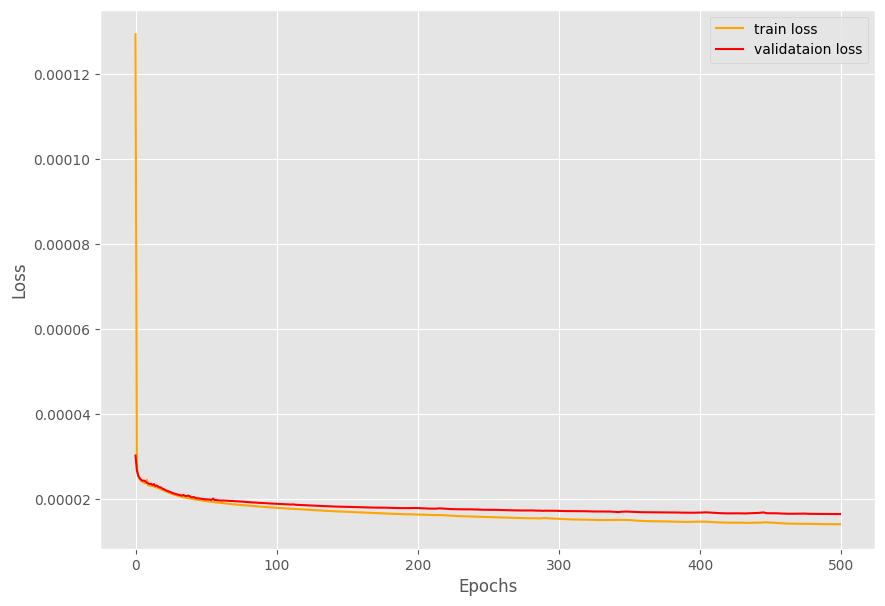

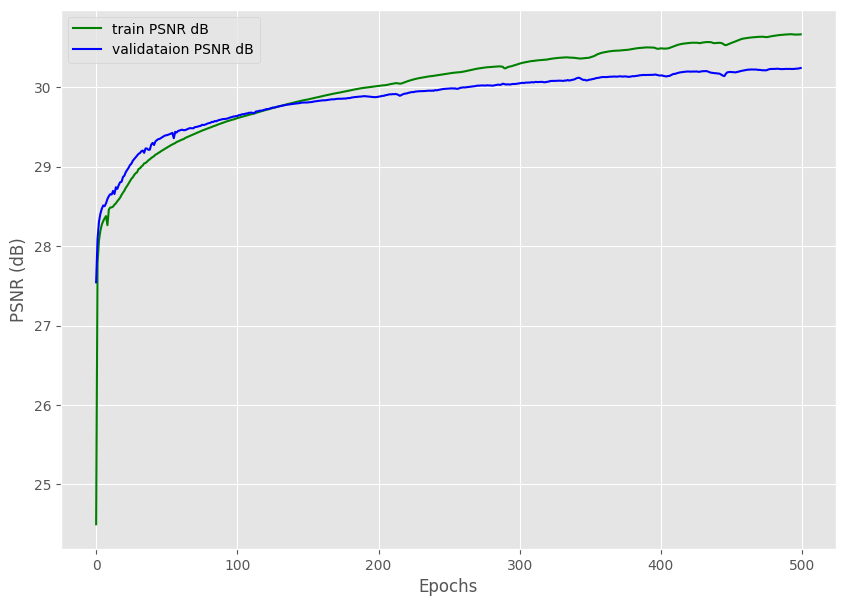

Saving model...


In [16]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('val_outputs/lossgpu.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('val_outputs/psnrgpubetter.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), 'val_outputs/modelgpu.pth')

In [17]:
image_paths = glob('input/bicubic_2x/*')
print(image_paths)

['input/bicubic_2x\\baby_GT.bmp', 'input/bicubic_2x\\bird_GT.bmp', 'input/bicubic_2x\\butterfly_GT.bmp', 'input/bicubic_2x\\head_GT.bmp', 'input/bicubic_2x\\woman_GT.bmp']


In [18]:
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    test_image_name = image_path.split(os.path.sep)[-1].split('.')[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    cv2.imwrite(f"outputs/test_{test_image_name}.png", image)
    image = image / 255. # normalize the pixel values
    cv2.imshow('Greyscale image', image)
    model.eval()
    with torch.no_grad():
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = image.unsqueeze(0)
        outputs = model(image)
    outputs = outputs.cpu()
    save_image(outputs, f"outputs/output_{test_image_name}.png")
    outputs = outputs.detach().numpy()
    outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
    print(outputs.shape)
    cv2.imshow('Output', outputs)


(504, 504, 1)
(288, 288, 1)
(252, 252, 1)
(276, 276, 1)
(336, 228, 1)


In [19]:
print("+")

+
